In [1199]:
import pandas as pd
import numpy as np


## General Preprocessing

In [1200]:
df = pd.read_csv('diabetic_data.csv')

In [1201]:
# Drop additional patient encounters

df.drop_duplicates(subset=['patient_nbr'], keep ='first', inplace=True)

In [1202]:
# Drop identifying columns
identifying_columns = ['encounter_id', 'patient_nbr']
df.drop(identifying_columns, axis=1, inplace=True)

In [1203]:
# Drop columns with high % of missing data
# codes based on https://hl7-definition.caristix.com/v2/HL7v2.4/Tables/0112
incomplete_columns = ['weight', 'payer_code', 'medical_specialty']
df.drop(incomplete_columns, axis=1, inplace=True)

In [1204]:
# Drop rows with unknown values
df.drop(df[df.race == "?"].index, inplace=True)
df.drop(df[df.gender == "Unknown/Invalid"].index, inplace=True)

# Drop rows with patients who are still in the hospital or expired (dead)

dispos_to_drop = [20, 21, 22, 23, 24, 25, 26 , 27, 28, 29, 40, 41, 49, 11, 13, 14, 19]
for i in dispos_to_drop:
    df.drop(df[df.discharge_disposition_id == i].index, inplace=True)

In [1205]:
df.shape

(65518, 45)

## Track the number of medications changed

In [1206]:
medicine_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

In [1207]:
# Create a dataframe from the medication columns
medicine_df = df[medicine_columns]


In [1208]:
# Define a function that returns 0 if there was no change and 1 if there was 
def is_changed(x):
    same = ['No', 'Steady']
    return 0 if x in same else 1

In [1209]:
# Apply that function to the entire medicine df, creating a data frame of 1s and 0s

medicine_df_temp = medicine_df.apply(lambda x: [is_changed(i) for i in x])

# Create a new column that sums each row
medicine_df_temp['num_meds_changed'] = medicine_df_temp.apply(np.sum, axis=1)


In [1210]:
# Validate values 

medicine_df_temp['num_meds_changed'].value_counts()

0    49458
1    15120
2      868
3       69
4        3
Name: num_meds_changed, dtype: int64

In [1211]:
# Add num_meds_changed to original df

df['num_meds_changed'] = medicine_df_temp['num_meds_changed']

# Dropping the medicine columns and the change column as num_meds_changed is now measuring the same thing
df.drop(medicine_columns, axis=1, inplace=True)
df.drop('change', axis=1, inplace=True)

In [1212]:
# Further validation

medicine_df_temp[medicine_df_temp['num_meds_changed']==4]

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,...,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,num_meds_changed
70821,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,4
73369,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,4
96599,1,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,4


In [1213]:
df.shape

(65518, 22)

## Track total number of visits in previous year

In [1214]:
df['total_hosp_visits'] = df['number_emergency'] + df['number_inpatient'] + df['number_outpatient']

In [1215]:
df.drop(['number_emergency', 'number_inpatient', 'number_outpatient'], axis=1, inplace=True)

In [1216]:
df.shape

(65518, 20)

In [1217]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'diabetesMed', 'readmitted', 'num_meds_changed', 'total_hosp_visits'],
      dtype='object')

## Encoding 

In [1218]:
age_groups = {
    "[0-10)": 0,
    "[10-20)": 1,
    "[20-30)":2,
    "[30-40)":3,
    "[40-50)":4,
    "[50-60)":5,
    "[60-70)":6,
    "[70-80)":7,
    "[80-90)":8,
    "[90-100)":9
}

df['age'] = df['age'].apply(lambda x: age_groups[x])

In [1219]:
gender_groups = {
    "Female": 0,
    "Male": 1
}

df['gender'] = df['gender'].apply(lambda x: gender_groups[x] )

In [1220]:
df.dtypes

race                        object
gender                       int64
age                          int64
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
diabetesMed                 object
readmitted                  object
num_meds_changed             int64
total_hosp_visits            int64
dtype: object

In [1221]:
df['A1Cresult'].value_counts()

None    53458
>8       5808
Norm     3543
>7       2709
Name: A1Cresult, dtype: int64

In [1222]:
# A1c test result

result_groups = {
    "None": 0,
    "Norm": 1,
    ">7":2,
    ">8":3
}

df['A1Cresult'] = df['A1Cresult'].apply(lambda x: result_groups[x])

In [1223]:
# Any diabetes medications prescribed?

meds = {
    "No": 0,
    "Yes": 1
}

df['diabetesMed'] = df['diabetesMed'].apply(lambda x: meds[x])

In [1224]:
# Glucose serum test amount

serum_amounts = {
    "None": 0,
    "Norm": 1,
    ">200": 2,
    ">300": 3
}


df['max_glu_serum'] = df['max_glu_serum'].apply(lambda x: serum_amounts[x])

In [1225]:
df['readmitted'].value_counts()

NO     38764
>30    21076
<30     5678
Name: readmitted, dtype: int64

In [1226]:
# Was the patient readmitted? If so in how long?

readmitted = {
    "NO": 0,
    "<30": 1,
    ">30": 2
}

df['readmitted'] = df['readmitted'].apply(lambda x: readmitted[x])

In [1227]:
df.dtypes

race                        object
gender                       int64
age                          int64
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum                int64
A1Cresult                    int64
diabetesMed                  int64
readmitted                   int64
num_meds_changed             int64
total_hosp_visits            int64
dtype: object

In [1228]:
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)

In [1229]:
object_columns = [i for i in df.columns if df[i].dtype == "object"]
dummy_columns = pd.get_dummies(df[object_columns])

df = pd.concat([df, dummy_columns], axis=1).drop(object_columns, axis=1)

In [1230]:
df

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,...,A1Cresult,diabetesMed,readmitted,num_meds_changed,total_hosp_visits,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other
1,0,1,1,1,7,3,59,0,18,9,...,0,1,2,1,0,0,0,1,0,0
2,0,2,1,1,7,2,11,5,13,6,...,0,1,0,0,3,1,0,0,0,0
3,1,3,1,1,7,2,44,1,16,7,...,0,1,0,1,0,0,0,1,0,0
4,1,4,1,1,7,1,51,0,8,5,...,0,1,0,0,0,0,0,1,0,0
5,1,5,2,1,2,3,31,6,16,9,...,0,1,2,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,0,7,1,1,7,9,50,2,33,9,...,2,1,2,1,0,0,0,1,0,0
101755,0,4,1,1,7,14,73,6,26,9,...,3,1,2,1,1,0,0,0,0,1
101756,0,6,1,1,7,2,46,6,17,9,...,0,1,2,0,3,0,0,0,0,1
101758,0,8,1,1,7,5,76,1,22,9,...,0,1,0,1,1,0,0,1,0,0


## RFC Test

In [1231]:
from sklearn.ensemble import RandomForestClassifier

test_df = df.copy()

X = test_df.drop('readmitted', axis=1).values
y = test_df['readmitted'].values

In [1232]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

In [1233]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1234]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=128, random_state=1).fit(X_train_scaled, y_train)

In [1235]:
from sklearn.metrics import accuracy_score

predictions = rf_model.predict(X_test_scaled)
acc_score = accuracy_score(y_test, predictions)

acc_score

0.5890567765567766

In [1236]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1", "Actual 2"], columns=["Predicted 0", "Predicted 1", "Predicted 2"])

cm_df

,Predicted 0,Predicted 1,Predicted 2
Actual 0,6614,16,1035
Actual 1,860,9,278
Actual 2,3181,15,1096


In [1237]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.62      0.86      0.72      7665
           1       0.23      0.01      0.02      1147
           2       0.45      0.26      0.33      4292

    accuracy                           0.59     13104
   macro avg       0.43      0.38      0.35     13104
weighted avg       0.53      0.59      0.53     13104



In [1238]:
importances = rf_model.feature_importances_

sorted(zip(rf_model.feature_importances_, test_df.drop('readmitted', axis=1).columns), reverse=True)

[(0.1951832976436312, 'num_lab_procedures'),
 (0.16245239245424875, 'num_medications'),
 (0.10782086296976348, 'time_in_hospital'),
 (0.08145649223156107, 'age'),
 (0.07279282856837556, 'num_procedures'),
 (0.06982466323295163, 'number_diagnoses'),
 (0.04430769530732434, 'discharge_disposition_id'),
 (0.0427857607631389, 'total_hosp_visits'),
 (0.03892217018387705, 'admission_type_id'),
 (0.033299539922822495, 'gender'),
 (0.03030676774671915, 'A1Cresult'),
 (0.029437727689145928, 'admission_source_id'),
 (0.027901353275016253, 'num_meds_changed'),
 (0.015452034848724858, 'race_Caucasian'),
 (0.014400820238888862, 'diabetesMed'),
 (0.014390047266218564, 'race_AfricanAmerican'),
 (0.008299189110484806, 'max_glu_serum'),
 (0.004898513591842281, 'race_Hispanic'),
 (0.004041053587391751, 'race_Other'),
 (0.0020267893678732806, 'race_Asian')]

## KNN Test

In [857]:
from sklearn.neighbors import KNeighborsClassifier

In [858]:
knn = KNeighborsClassifier(n_neighbors=1)

In [859]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.61      0.89      0.72      7665
           1       0.50      0.00      0.01      1147
           2       0.45      0.20      0.27      4292

    accuracy                           0.59     13104
   macro avg       0.52      0.36      0.33     13104
weighted avg       0.55      0.59      0.51     13104



In [860]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

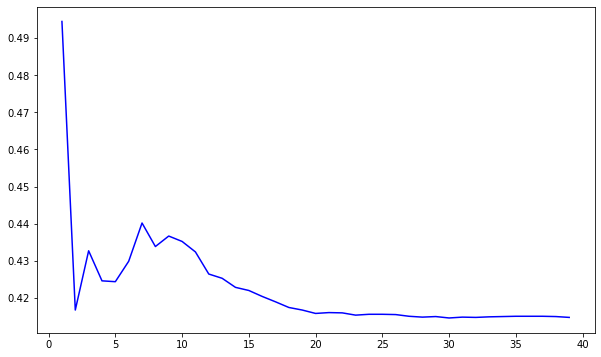

In [861]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate, color="blue")

In [862]:
knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(X_train_scaled, y_train)

pred = knn.predict(X_test_scaled)

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.60      0.84      0.70      7665
           1       0.10      0.07      0.08      1147
           2       0.38      0.13      0.19      4292

    accuracy                           0.54     13104
   macro avg       0.36      0.35      0.33     13104
weighted avg       0.48      0.54      0.48     13104



## Logistic Regression

In [1073]:
from sklearn.linear_model import LogisticRegression

In [1074]:
logit_X = test_df.drop('readmitted', axis=1).values
logit_y = test_df['readmitted'].replace({2:1}).values

In [1075]:
logit_X_train, logit_X_test, logit_y_train, logit_y_test = train_test_split(logit_X, logit_y, random_state=1, test_size=0.2)

In [1076]:
logit_scaler = StandardScaler().fit(logit_X_train_resampled)

logit_X_train_scaled = logit_scaler.transform(logit_X_train)
logit_X_test_scaled = scaler.transform(logit_X_test)

In [1077]:
clf = LogisticRegression(random_state=0).fit(logit_X_train_scaled, logit_y_train)

In [1078]:
clf.score(logit_X_test_scaled, logit_y_test)

0.6059218559218559